In [1]:
cd ..

c:\Users\jeong\Desktop\python-practices\reid-practice


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils
import torch.utils.data
import torchvision
import torchvision.transforms

import reid.datasets.paired
import reid.losses
import reid.models
import reid.utilities

In [3]:
# Get Device
device = reid.utilities.device()
reid.utilities.manual_seed(777)

In [4]:
# Prepare Datasets
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_inv = torchvision.transforms.Compose([
    torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2)),
])

dataset_omni = torchvision.datasets.Omniglot('./data/omniglot', transform=transform)
dataset_train = reid.datasets.paired.DoublePairedVisionDataset(
    dataset_omni)
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=2048,
                                               shuffle=True,
                                               num_workers=0)

In [5]:
# Create Model
model = reid.models.resnet18_custom(True)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
model.to(device)
criterion = reid.losses.ContrastiveLoss(4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [6]:
# Or Load
# model = reid.models.resnet18_custom(False)
# model.load_state_dict(torch.load('./model_epoch_49.pth'))
# model = model.to(device).eval()

In [7]:
# Train
loss_epoch = []
num_epochs = 30
for epoch in range(num_epochs):
    loss_batch = 0.0
    lr_sche.step()
    for i, batch in enumerate(dataloader_train, 0):
        inputs0, inputs1, labels = batch
        inputs0 = inputs0.to(device)
        inputs1 = inputs1.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = criterion(model(inputs0), model(inputs1), labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        loss_batch += loss
    loss_batch /= i+1
    print(f'epoch: {epoch}, loss: {loss_batch}')
    loss_epoch.append(loss_batch)

    if epoch % 10 == 9:
        torch.save(model.state_dict(), "./contrastive_res18_omni_epoch_{}.pth".format(epoch+1))

epoch: 0, loss: 532.6116943359375
epoch: 1, loss: 5.509158611297607
epoch: 2, loss: 5.018037796020508
epoch: 3, loss: 4.770081520080566
epoch: 4, loss: 4.639629364013672
epoch: 5, loss: 4.561245918273926
epoch: 6, loss: 4.523568630218506
epoch: 7, loss: 4.491864204406738
epoch: 8, loss: 4.485782146453857
epoch: 9, loss: 4.469963550567627
epoch: 10, loss: 4.461818695068359
epoch: 11, loss: 4.447057247161865
epoch: 12, loss: 4.442657470703125
epoch: 13, loss: 4.436303615570068
epoch: 14, loss: 4.450662136077881
epoch: 15, loss: 4.422923564910889
epoch: 16, loss: 4.404461860656738
epoch: 17, loss: 4.395990371704102
epoch: 18, loss: 4.395062446594238
epoch: 19, loss: 4.392040252685547
epoch: 20, loss: 4.381389141082764
epoch: 21, loss: 4.384133338928223
epoch: 22, loss: 4.391503810882568
epoch: 23, loss: 4.387004375457764
epoch: 24, loss: 4.391646862030029
epoch: 25, loss: 4.3823628425598145
epoch: 26, loss: 4.3676886558532715
epoch: 27, loss: 4.388002872467041
epoch: 28, loss: 4.369709968

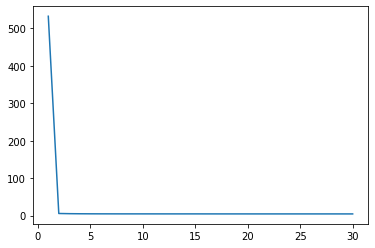

In [8]:
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_epoch)
plt.show()

In [9]:
# Test
def visualize_batch(model, batch, transform, device):
    anchors, others, labels = batch

    for i in range(len(anchors)):
        anchor = anchors[i].unsqueeze(dim=0).to(device)
        other = others[i].unsqueeze(dim=0).to(device)

        # calc distance between anchor and X
        output_anchor = model(anchor)
        output_other = model(other)
        distance = torch.nn.functional.pairwise_distance(
            output_anchor, output_other)

        # make grid
        imgs = torch.cat((transform(anchor), transform(other)), 0)
        plt.imshow(
            torchvision.utils.make_grid(imgs).cpu().permute(1, 2, 0))
        plt.text(75,
                 8,
                 'dist: {:.8f}'.format(distance.item()),
                 fontweight='bold',
                 bbox={
                     'facecolor': 'white',
                     'alpha': 0.8,
                     'pad': 10
                 })
        plt.show()

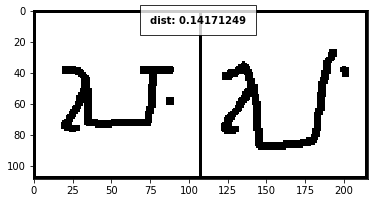

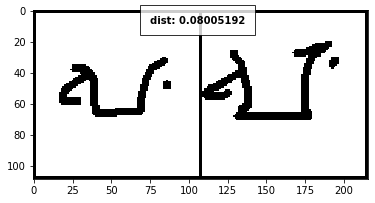

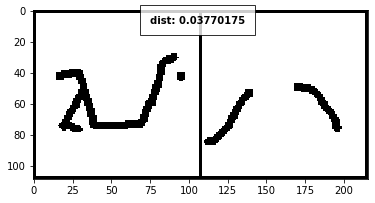

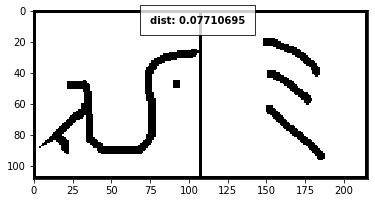

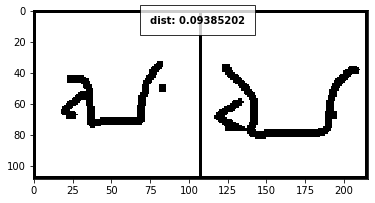

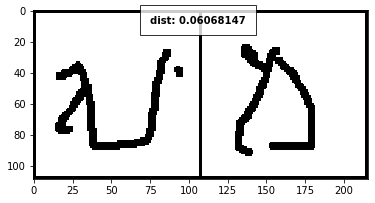

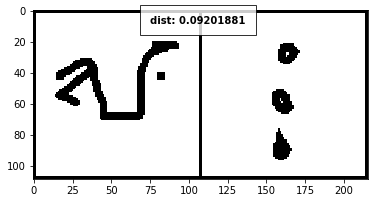

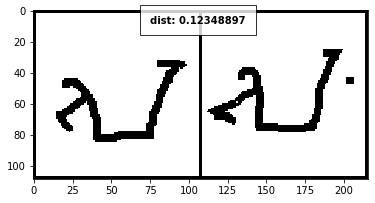

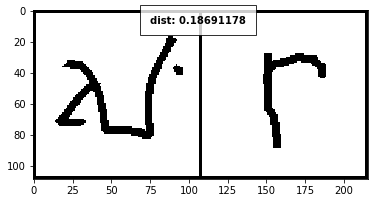

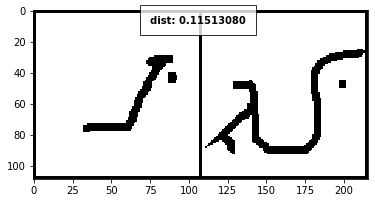

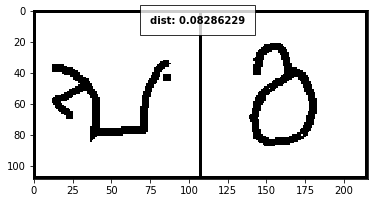

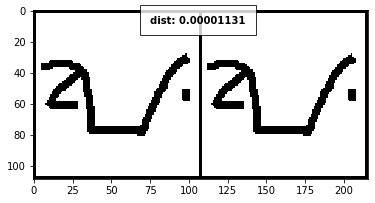

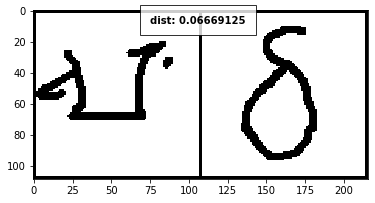

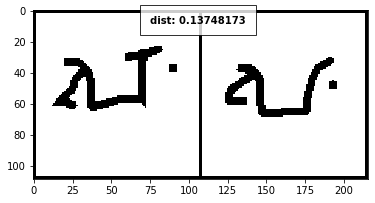

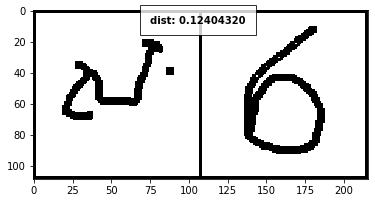

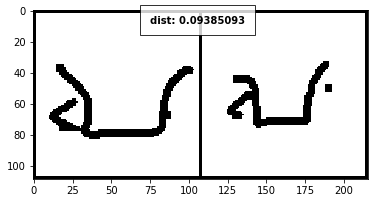

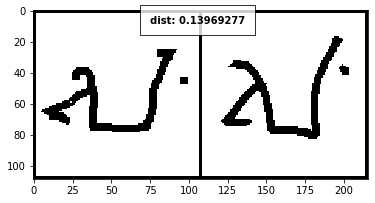

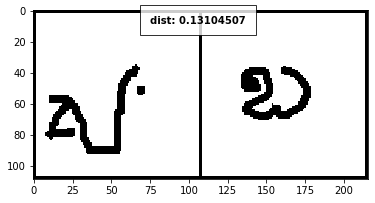

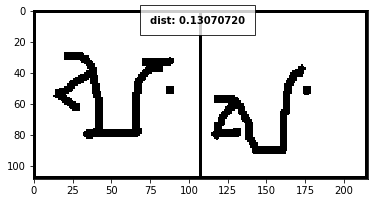

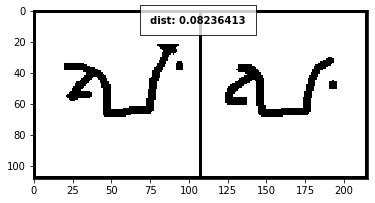

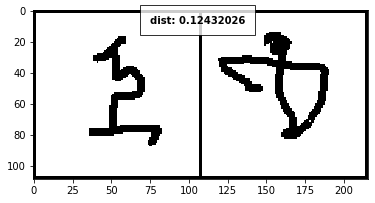

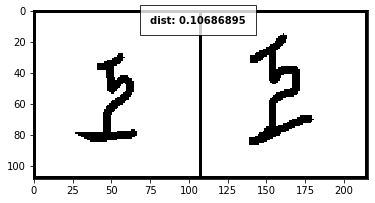

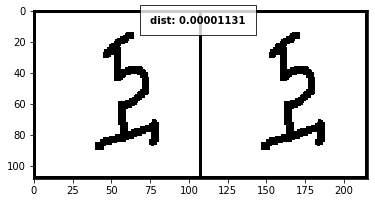

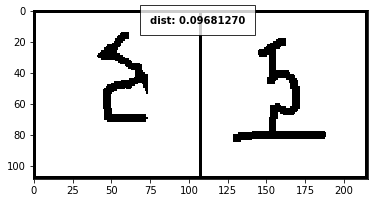

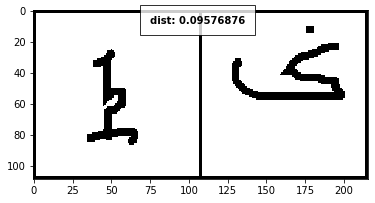

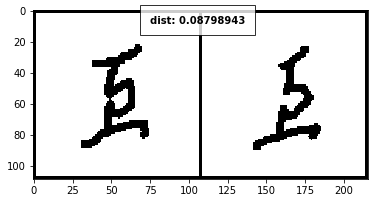

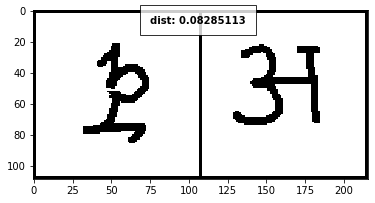

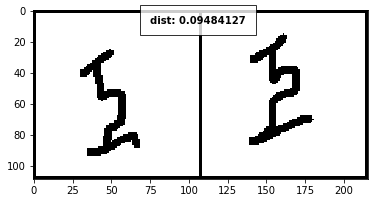

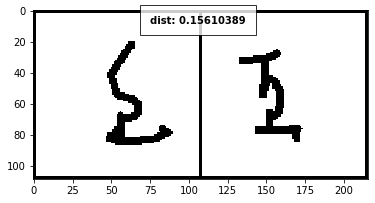

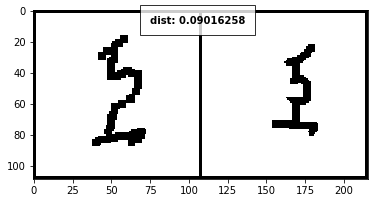

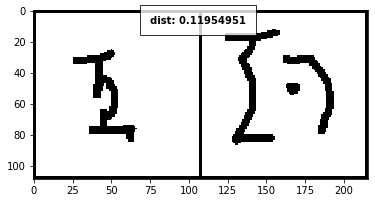

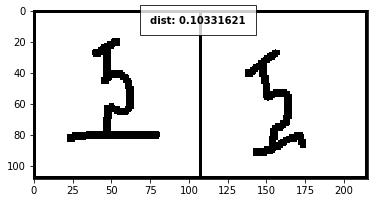

In [20]:
dataloader_test = torch.utils.data.DataLoader(dataset_train,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=0)
batch = next(iter(dataloader_test))
visualize_batch(model, batch, transform_inv, device)

In [23]:
f'classes: {len(dataset_train._classes)}, size: {len(dataset_train)}'

'classes: 964, size: 19280'